In [1]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm

In [2]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1 
    else:
        return len(geometry.geoms)

In [3]:
with open("../states.json", "r") as f:
    states = json.load(f)
state = "PA"
DEGREE_LIMIT = 0
voting_precincts = gpd.read_file(states[state]["FILE"])
voting_precincts = voting_precincts.to_crs("EPSG:4269")
# voting_precincts = voting_precincts.dissolve(by="COUNTYFP", aggfunc="sum")
n_districts = states[state]["NUM_OF_DISTRICTS"]
pop = states[state]["POPULATION"]
d_votes = states[state]["DEMOCRAT_VOTES"]
r_votes = states[state]["REPUBLICAN_VOTES"]
print(voting_precincts.columns)
voting_precincts.sample(n=1)

Index(['GEOID20', 'G18GOVRWAG', 'G18USSDCAS', 'NAME', 'G18USSLKER', 'VTDST',
       'STATEFP', 'G18USSGGAL', 'COUNTYFP', 'G18USSRBAR', 'G18GOVDWOL',
       'G18GOVGGLO', 'G18GOVLKRA', 'VTDST20', 'G16TRERVOI', 'NAMELSAD20',
       'AWATER20', 'LSAD20', 'G16AUDGSWE', 'NAME20', 'G16AUDRBRO',
       'G16PRERTRU', 'G16TRELBAB', 'COUNTYFP20', 'G16TREGCOM', 'G16PREDCLI',
       'STATEFP20', 'G16USSRTOO', 'G16PRECCAS', 'G16USSLCLI', 'G16AUDDDEP',
       'G16USSDMCG', 'FUNCSTAT20', 'INTPTLAT20', 'G16TREDTOR', 'G16ATGRRAF',
       'G16ATGDSHA', 'G16PREGSTE', 'ALAND20', 'G16PRELJOH', 'G16AUDLMIN',
       'INTPTLON20', 'VTDI20', 'MTFCC20', 'TOTPOP19', 'TOTPOP10', 'HPOP19',
       'HCVAP19', 'HPOP10', 'NHPICVAP19', 'NHCVAP19', 'NHPOP19', 'NHPIPOP19',
       'NHPOP10', '2MOREPOP19', '2MORECVAP1', '2MOREPOP10', 'ASIANPOP19',
       'ASIANCVAP1', 'ASIANPOP10', 'AMINPOP19', 'AMINCVAP19', 'AMINPOP10',
       'BCVAP19', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WCVAP19',
       'WPOP10', 'CVAP19', 'geo

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,AMINPOP10,BCVAP19,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry
6669,42101001708,2.0,296.0,PHILADELPHIA WARD 17 PRECINCT 08,2.0,001708,42,1.0,101,2.0,...,1.0,486.238761,519.312812,742.0,0.0,10.333333,10.0,8.0,667.488618,"POLYGON ((-75.15795 40.04922, -75.15792 40.049..."


In [4]:
# voting_precincts = voting_precincts.to_crs("EPSG:4269")
# voting_precincts['GEOID20'] = voting_precincts['GEOID20'].astype(str)

print([x for x in voting_precincts.columns if "POP" in x.upper()])
print([x for x in voting_precincts.columns if "D" in x.upper()])
print(voting_precincts.shape)
# voting_precincts.sample(n=5)

['TOTPOP19', 'TOTPOP10', 'HPOP19', 'HPOP10', 'NHPOP19', 'NHPIPOP19', 'NHPOP10', '2MOREPOP19', '2MOREPOP10', 'ASIANPOP19', 'ASIANPOP10', 'AMINPOP19', 'AMINPOP10', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WPOP10']
['GEOID20', 'G18USSDCAS', 'VTDST', 'G18GOVDWOL', 'VTDST20', 'NAMELSAD20', 'LSAD20', 'G16AUDGSWE', 'G16AUDRBRO', 'G16PREDCLI', 'G16AUDDDEP', 'G16USSDMCG', 'G16TREDTOR', 'G16ATGDSHA', 'ALAND20', 'G16AUDLMIN', 'VTDI20']
(9178, 72)


In [5]:
voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
voting_precincts['RP_LON'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
voting_precincts['RP_LAT'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(voting_precincts.shape)
# voting_precincts.sample(n=5)

C:\Users\yagne\AppData\Local\Temp/ipykernel_17064/1766291162.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263


(9178, 75)


In [6]:
orig_voting = voting_precincts[[d_votes, r_votes]].sum()/(voting_precincts[[d_votes, r_votes]].sum().sum())
orig_voting

G18GOVDWOL    0.586676
G18GOVRWAG    0.413324
dtype: float64

In [19]:
def entropy_score_parta_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score = entropy([dem_prop_1, rep_prop_1], base=2)

    # Will always minimize, for entropy negate
    return -score

def entropy_score_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = entropy([dem_prop_1, rep_prop_1], base=2)

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = entropy([dem_prop_2, rep_prop_2], base=2)

    score = (score_1+score_2)/2 # Average of both
    # Will always minimize, for entropy negate
    return -score
    

def abs_diff_parta_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score = abs(dem_prop_1-rep_prop_1) 
    return score
    
def abs_diff_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = abs(dem_prop_1-rep_prop_1) 

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = abs(dem_prop_2-rep_prop_2)

    score = (score_1+score_2) # Average of both
    return score

def match_statewide_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    orig_dem = kwargs["orig_dem"]
    orig_rep = kwargs["orig_rep"]
    # Always takes in both dataframes
    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = abs(dem_prop_1-orig_dem)+abs(rep_prop_1-orig_rep)

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = abs(dem_prop_2-orig_dem)+abs(rep_prop_2-orig_rep)

    score = (score_1+score_2)/2 # Average of both
    return score


def equalize_voting(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes
    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])

    score = abs(dem_prop_1-dem_prop_2) 
    return score




In [32]:
# %%time
def split_this(df, n_districts, n_split=1, pop_col = "POPULATION", dem_col = "G18GOVD", rep_col = "G18GOVR", score_fn=abs_diff_parta_fn, n_sample_angles=None, degree_limit = 0, dissolve_check = False):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df[pop_col].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df[pop_col]).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df[pop_col]).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        # df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        if n_sample_angles:
            start_angles = np.random.choice(start_angles, size=n_sample_angles)
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in tqdm(start_angles):
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, pop_col]
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']

            ## Check if angle range loops past 360 for conditions:
            a1, a2 = d, final_angle

            # If specified, skip past any second hand angle that is not far away from the first handle angle.
            if abs(a2 - a1) <= degree_limit:
                continue

            if a1 < a2:
                    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
            elif a1 > a2:
                    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

            # Dissolve Check for Non-Contiguity
            if dissolve_check:
                dissolved_df = df.dissolve(by=f'SPLIT_{n_split}')
                dissolved_df['disjoints'] = dissolved_df['geometry'].apply(lambda x: count_disjoints(x))
                dissolved_pieces = dissolved_df['disjoints'].sum()
            else:
                dissolved_pieces = 0

            df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)


            # Metric Calculation, Change to any function chosen.
            score = score_fn(df_a, df_b, dem_col, rep_col, orig_dem=orig_voting[dem_col], orig_rep=orig_voting[rep_col])
            angle_ranges.append({"start":d, "end":final_angle, "score":score, "disjoints": dissolved_pieces})


        ars = pd.DataFrame(angle_ranges)
        # ars['entropy_prod'] = (ars['entropy_a']*ars["entropy_b"])/(ars['entropy_a']+ars["entropy_b"])
        # ars = ars.sort_values("entropy_prod", ascending=False).reset_index(drop=True)
        ars = ars.sort_values(["disjoints","score"], ascending=True).reset_index(drop=True)

        a1, a2 = ars.iloc[0]["start"], ars.iloc[0]["end"]
        ## Check if angle range loops past 360 for conditions:
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles, degree_limit=degree_limit, score_fn=score_fn)
        split_this(df_b, part_b, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles, degree_limit=degree_limit, score_fn=score_fn)

        
    else:
        holder.append(df)

holder = []   
split_this(df=voting_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes, degree_limit=DEGREE_LIMIT, score_fn=equalize_voting)

100%|██████████| 360/360 [00:03<00:00, 90.84it/s]


In [33]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [34]:
all_districts['DISTRICT'].nunique()

18

In [35]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [36]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
all_districts.groupby("SHUFFLED").sum()[pop]

12791530.0


SHUFFLED
0.0     711424.428654
1.0     709906.703060
2.0     709264.328986
3.0     710099.998134
4.0     710570.715141
5.0     713209.467299
6.0     709942.944759
7.0     706785.762619
8.0     711393.742724
9.0     707974.233966
10.0    711474.205435
11.0    712185.895776
12.0    710531.169783
13.0    709685.229260
14.0    709650.113405
15.0    713641.778089
16.0    711052.379123
17.0    712736.903786
Name: TOTPOP19, dtype: float64

In [37]:
all_districts.columns

Index(['GEOID20', 'G18GOVRWAG', 'G18USSDCAS', 'NAME', 'G18USSLKER', 'VTDST',
       'STATEFP', 'G18USSGGAL', 'COUNTYFP', 'G18USSRBAR', 'G18GOVDWOL',
       'G18GOVGGLO', 'G18GOVLKRA', 'VTDST20', 'G16TRERVOI', 'NAMELSAD20',
       'AWATER20', 'LSAD20', 'G16AUDGSWE', 'NAME20', 'G16AUDRBRO',
       'G16PRERTRU', 'G16TRELBAB', 'COUNTYFP20', 'G16TREGCOM', 'G16PREDCLI',
       'STATEFP20', 'G16USSRTOO', 'G16PRECCAS', 'G16USSLCLI', 'G16AUDDDEP',
       'G16USSDMCG', 'FUNCSTAT20', 'INTPTLAT20', 'G16TREDTOR', 'G16ATGRRAF',
       'G16ATGDSHA', 'G16PREGSTE', 'ALAND20', 'G16PRELJOH', 'G16AUDLMIN',
       'INTPTLON20', 'VTDI20', 'MTFCC20', 'TOTPOP19', 'TOTPOP10', 'HPOP19',
       'HCVAP19', 'HPOP10', 'NHPICVAP19', 'NHCVAP19', 'NHPOP19', 'NHPIPOP19',
       'NHPOP10', '2MOREPOP19', '2MORECVAP1', '2MOREPOP10', 'ASIANPOP19',
       'ASIANCVAP1', 'ASIANPOP10', 'AMINPOP19', 'AMINCVAP19', 'AMINPOP10',
       'BCVAP19', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WCVAP19',
       'WPOP10', 'CVAP19', 'geo

In [44]:
all_districts[['geometry', pop, r_votes, d_votes, 'DISTRICT', 'SHUFFLED'] + split_columns].to_file(f"{state}_comp.shp")

c:\Users\yagne\.conda\envs\gerrymandering\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

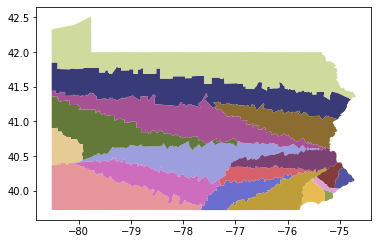

In [38]:
districts_df = all_districts.dissolve(by="SHUFFLED")
districts_df.plot(cmap="tab20b")

## Step by Step Review

In [39]:
def split_review(input_df, split, split_cols, plot_party=False, figsize = (8,6), save=None):
    input_df['TEMP_DISTRICT'] = input_df.apply(splits_to_regions_binary, splits=split_cols[:split], axis=1)
    n_districts = input_df['TEMP_DISTRICT'].nunique()
    # random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
    random_districts = np.linspace(0,n_districts-1,n_districts)
    shuffle_dict = dict(zip(input_df["TEMP_DISTRICT"].unique(), random_districts))
    input_df["TEMP_DISTRICT"] = input_df["TEMP_DISTRICT"].apply(lambda x: shuffle_dict[x])

    districts_df = input_df.dissolve(by = "TEMP_DISTRICT", aggfunc={"TEMP_DISTRICT": "first", d_votes: "sum", r_votes: "sum"})
    districts_df["Dem_Ratio"] = districts_df[d_votes]/(districts_df[d_votes] + districts_df[r_votes])
    districts_df["Rep_Ratio"] = districts_df[r_votes]/(districts_df[d_votes] + districts_df[r_votes])

    
    fig, ax = plt.subplots(1,1, figsize=figsize)

    if plot_party:
        base = districts_df.plot(ax=ax, cmap="RdBu", column="Dem_Ratio", legend=True, vmin=0, vmax=1, edgecolor='black')
        dem_wins = districts_df.loc[districts_df["Dem_Ratio"] >= districts_df["Rep_Ratio"]].shape[0]
        rep_wins = districts_df.loc[districts_df["Dem_Ratio"] < districts_df["Rep_Ratio"]].shape[0]
        title = f"Districts: {districts_df.shape[0]} | D-R: {dem_wins}-{rep_wins}"
    else:
        base = districts_df.plot(ax=ax, cmap="tab20b", edgecolor='black')
        title = f"Districts - {districts_df.shape[0]}"
    

    points = []
    for x in range(2**split):
        sub = input_df.loc[input_df['TEMP_DISTRICT'] == x]
        if sub.shape[0] == 0:
            continue
        pop_center_LON = (sub['RP_LON'] * sub[pop]).sum()/sub[pop].sum()
        pop_center_LAT =  (sub['RP_LAT'] * sub[pop]).sum()/sub[pop].sum()
        point = shapely.geometry.Point(pop_center_LON, pop_center_LAT)
        points.append(point)
    pop_center_df = gpd.GeoDataFrame(geometry=points)
    pop_center_df.plot(ax=ax, color="white", linewidth=1.0, edgecolor="black")
    plt.title(title)
    if save:
        fig.savefig(save)
    plt.show()

    return districts_df


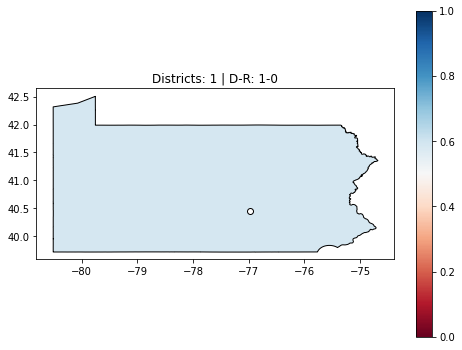

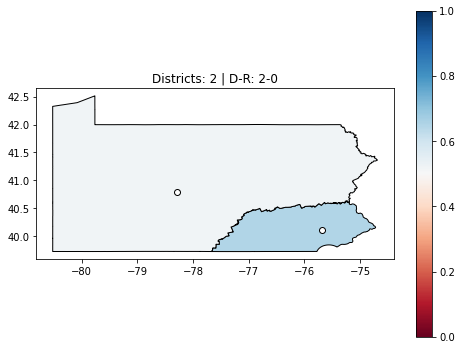

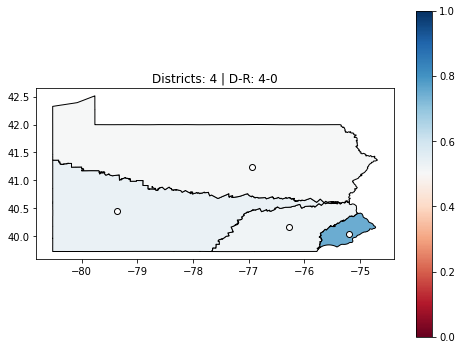

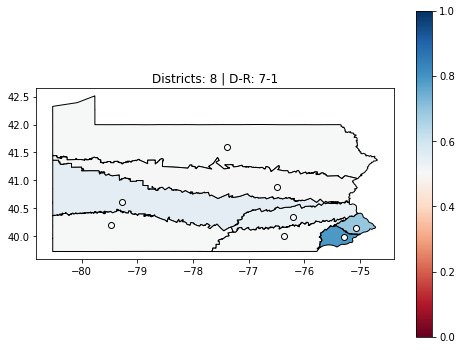

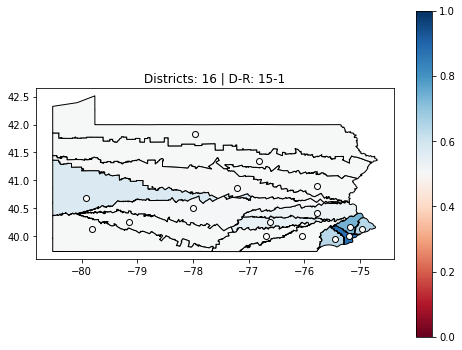

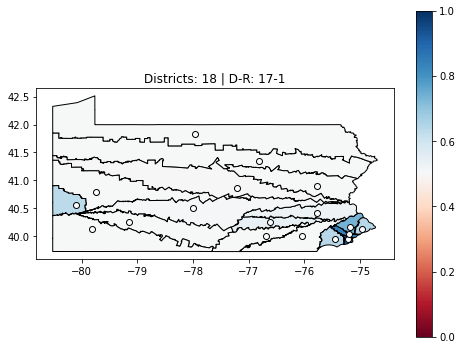

In [40]:
for s in range(len(split_columns)+1):
    _ = split_review(input_df=all_districts, split=s, split_cols=split_columns, plot_party=True)

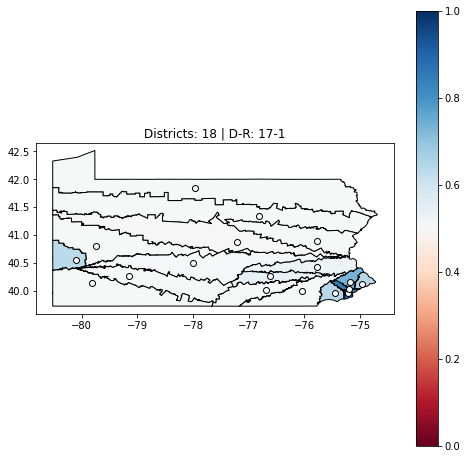

In [41]:
_ = split_review(input_df=all_districts, split=5, split_cols=split_columns, plot_party=True, figsize=(8,8), save=f"{state}_final.png")

In [43]:
_.sort_values("Rep_Ratio")

,geometry,TEMP_DISTRICT,G18GOVDWOL,G18GOVRWAG,Dem_Ratio,Rep_Ratio
TEMP_DISTRICT,,,,,,
0.0,"POLYGON ((-75.28275 39.88216, -75.28262 39.882...",0.0,259674.261000,27196.815631,0.905195,0.094805
1.0,"POLYGON ((-75.31548 40.02262, -75.31551 40.022...",1.0,204713.129023,38287.280582,0.842439,0.157561
3.0,"POLYGON ((-75.26325 40.09139, -75.26364 40.091...",3.0,252299.691472,90542.574842,0.735906,0.264094
4.0,"POLYGON ((-75.08041 40.03294, -75.08146 40.032...",4.0,167591.000000,94159.000000,0.640271,0.359729
2.0,"POLYGON ((-75.76984 39.77916, -75.76968 39.779...",2.0,211925.771432,119299.833497,0.639823,0.360177
9.0,"POLYGON ((-80.37557 40.38883, -80.37702 40.389...",9.0,195905.006651,112572.769652,0.635070,0.364930
7.0,"MULTIPOLYGON (((-77.31239 40.16222, -77.31215 ...",7.0,154430.092726,130198.496175,0.542567,0.457433
8.0,"POLYGON ((-76.46172 40.33951, -76.46175 40.339...",8.0,137602.264760,124144.603262,0.525707,0.474293
11.0,"MULTIPOLYGON (((-80.04636 40.40979, -80.04628 ...",11.0,131079.879230,128274.751234,0.505408,0.494592
